# Сетевое взаимодействие и архитектура web-серверов

## Цели занятия

1. Рассмотреть низкоуровневые механизмы клиент-серверного взаимодействия
2. Изучить модули стандартной библиотеки для создания клиент-серверных приложений 
3. Изучить основные виды архитектур веб серверов
4. Сравнить версии протокола HTTP и их применимость
5. Рассмотреть протокол Websocket и случаи его использования

## Содержание

- Понятие сетевых сокетов и стандартные модули для работы с ними
  - Зачем нужны сетевые сокеты и их виды
  - Модуль `socket`
  - Модуль `socketserver`
- Архитектура веб серверов
  - Forking
  - Threading
  - Event based
- Протокол HTTP
  - Сравнение версий протокола
  - Поддержка разных версий в Python
- Протокол Websocket
  - Общая информация
  - Библиотека `websockets`

## Понятие сетевых сокетов и стандартные модули для работы с ними

### Зачем нужны сетевые сокеты и их виды

**Сетевой сокет** - это абстракция, с помощью которой можно настроить взаимодействие между разными процессами. Взаимодействующие процессы могут находиться как на одной машине, так и на разных машинах связанных по сети. Классический пример процессов, которые хотят общаться друг с другом - веб клиент и веб сервер

Сетевые сокеты еще называют **Berkeley sockets** или **BSD sockets**

За тонкости реализации абстракции отвечает ОС, а программист получает удобный и стандартный программный интерфейс (API), с помощью которого легко писать прикладные программы

С точки зрения написания программы сокет выглядит как обычный file-like объект - в него можно что-то написать и что-то прочитать из него:
- если приложение хочет отправить какие-то данные другому процессу, оно пишет данные в сокет - `write`
- если приложение хочет получить какие-то данные от другого процесса, оно читает данные из сокета - `read`

Схематичное представление сетевого сокета

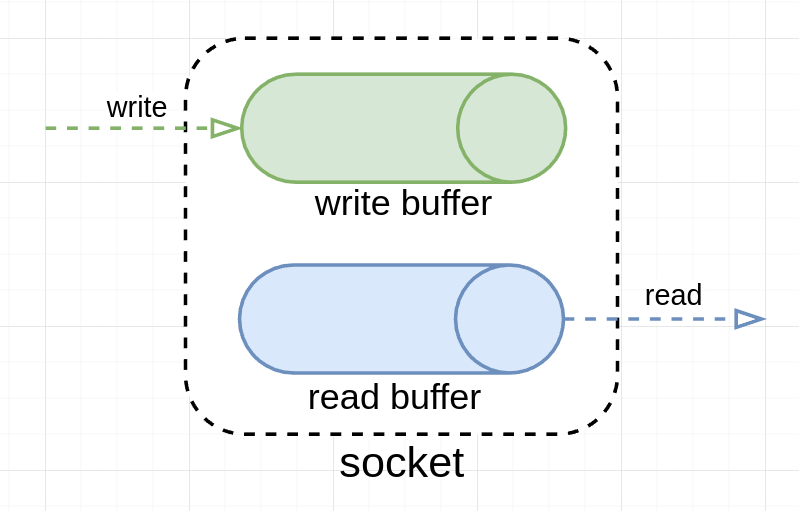

В прикладном веб программировании чаще всего используется 2 типа сетевых сокетов:
- _Stream Socket_ (`SOCK_STREAM`) - обеспечивает надежную, ориентированную на соединение передачу
данных, реализует протокол TCP
- _Datagram Socket_ (`SOCK_DGRAM`) - предоставляет передачу данных без установления соединения, реализует протокол UDP

Разные типы нужны для решения разных задач, а значит и способ взаимодействия с этими сокетами (интерфейс) с точки зрения программы тоже разный

API _Stream Socket_ (`SOCK_STREAM`)

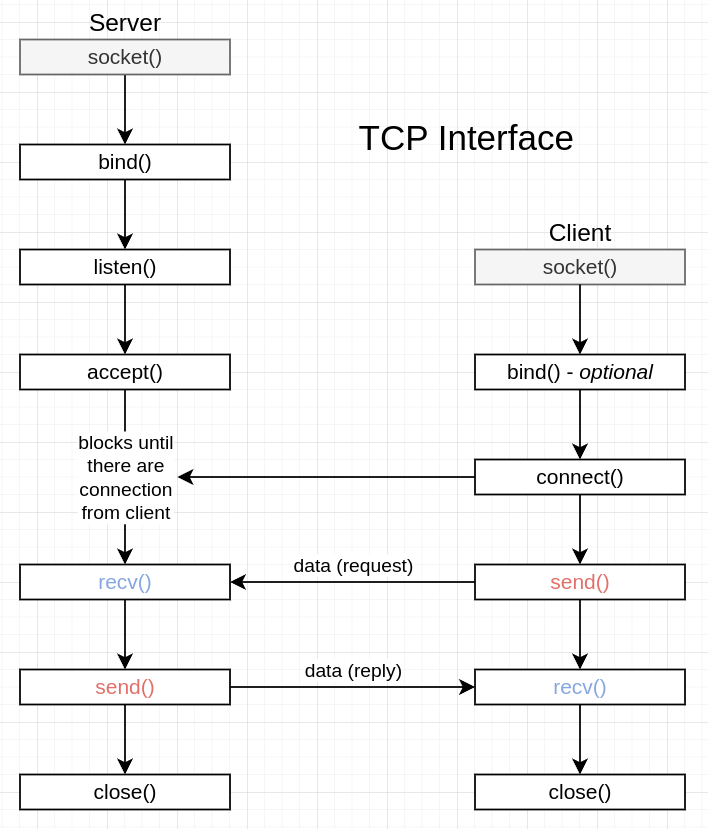

API _Datagram Socket_ (`SOCK_DGRAM`)

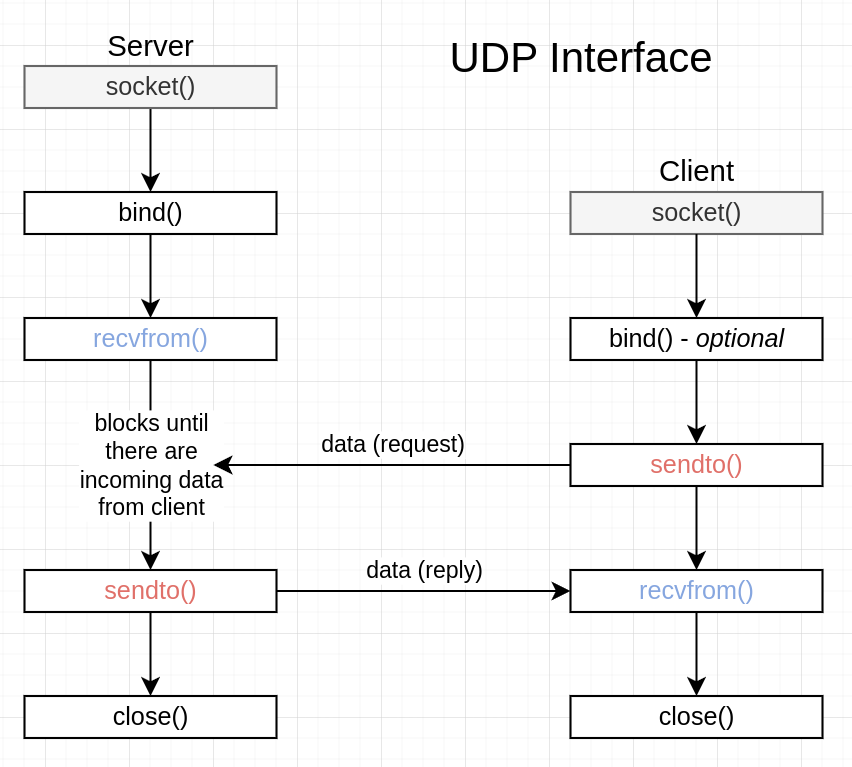

Исчерпывающую справку по системным вызовам можно получить в мане - `man 2 <sys-call-name>`

In [2]:
# ! man 2 bind

### Модуль `socket`

Стандартный модуль `socket` представляет самый низкоуровневый API для работы с сетевыми сокетами

[socket — Low-level networking interface](https://docs.python.org/3/library/socket.html)

#### TCP сервер и клиент

Представим, что мы решили реализовать простой, но надежный прикладной протокол поверх транспортного протокола TCP, назовем его `upper_reliable_V1`

Суть протокола:
- клиент отправляет серверу сообщение любой длины в кодировке UTF-8
- сервер отправялет клиенту в ответ этот же текст, но преобразованный в верхний регистр
- граница сообщения определяется последовательностью символов ` END`

О том, что клиент отправил весь текст, который хотел отправить, сервер понимает по наличию последовательности символов ` END`, как только сервер видит ` END` в сообщении, он понимает, что сообщение от клиента получено полностью и пора отправлять ответ

Чтобы клиент мог понять, когда ответ сервера полностью сформирован, он также ожидает последовательность символов ` END`

Код сервера (синхронный сервер, обрабатывает одного клиента за раз)

In [2]:
# file: upper_server_tcp.py

import socket

MSG_TERMINATOR = b" END"


def listen_and_serve_forever() -> None:
    """Сервер, который реализует выдуманный протокол upper_reliable_V1"""

    listening_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

    with listening_socket:
        # позволяет не дожидаться, пока старый сокет проживет состояние TIME_WAIT
        listening_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)

        # socket.AF_INET требует указания адреса хоста и порта
        # другие домены могут требовать другие аргументы
        # например, socket.AF_UNIX требует указать имя файла
        listening_socket.bind(("127.0.0.1", 9090))

        # аргумент 5 это backlog - максимальный размер очереди ожидающих подключения клиентов
        listening_socket.listen(5)

        print(f"сервер слушает {listening_socket.getsockname()}")

        while True:
            # .accept() блокирующий вызов, он вернет управление тогда, когда подключится очередной клиент
            # client_addr зависит от домена, для AF_INET это адрес хоста и порт
            # для других доменов будут другие значения
            connected_socket, client_addr = listening_socket.accept()

            print(f"новое подключение от {client_addr}")

            socket_closed_by_client = False
            client_request_processed = False
            with connected_socket:
                while not client_request_processed:
                    print(f"накапливаем сообщение клиента {client_addr}")

                    client_message = b""
                    while not client_message.endswith(MSG_TERMINATOR):
                        # .recv() блокирующий вызов, он вернет управление тогда,
                        # когда в буфере сокета накопится хотя бы 1 байт
                        # message_chunk может быть меньше чем 32 байт, но гарантированно не больше
                        message_chunk = connected_socket.recv(32)

                        print(f"получили от клиента {len(message_chunk)} байт")

                        # клиент закрыл свой сокет
                        if not message_chunk:
                            socket_closed_by_client = True
                            break

                        client_message += message_chunk

                    if socket_closed_by_client:
                        print(f"клиент {client_addr} прервал соединение")
                        client_request_processed = True
                        break

                    # очищаем сообщения от маркер ` END` в конце
                    client_message = client_message[0 : -len(MSG_TERMINATOR)]
                    # обрабатываем сообщение в соответствии с нашим протоколом
                    client_message = client_message.upper()

                    print(f"достигнут конец сообщения клиента {client_addr}")

                    # добавляем в конец ответного сообщения маркер ` END`
                    data_to_send = client_message + MSG_TERMINATOR

                    # .sendall() блокирующий вызов, он вернет управление тогда,
                    # когда в сокет запишется вся последовательность байт `data_to_send`
                    connected_socket.sendall(data_to_send)

                    # сообщаем, что больше ничего из сокета читать не собираемся
                    # и писать в него тоже не собираемся
                    connected_socket.shutdown(socket.SHUT_RD | socket.SHUT_WR)

                    print(f"клиент {client_addr} получил ответ")
                    client_request_processed = True

            print("---")

Код клиента

In [3]:
# file: upper_client_tcp.py

import socket

MSG_TERMINATOR = b" END"


def make_request_to_server(msg: str) -> None:
    """Клиент, который реализует выдуманный протокол upper_reliable_V1

    Args:
        msg (str): какое сообщение отправить серверу
    """

    client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

    with client_socket:
        # socket.AF_INET требует указания адреса хоста и порта
        # другие домены могут требовать другие аргументы
        # например, socket.AF_UNIX требует указать имя файла
        client_socket.connect(("127.0.0.1", 9090))

        # чтобы передать строку в сокет, ее необходимо преобразовать в байты
        data_to_send: bytes = msg.encode(encoding="utf-8") + MSG_TERMINATOR

        # .sendall() блокирующий вызов, он вернет управление тогда,
        # когда в сокет запишется вся последовательность байт `data_to_send`
        client_socket.sendall(data_to_send)

        # сообщаем, что больше ничего в сокет писать не собираемся
        client_socket.shutdown(socket.SHUT_WR)

        server_message = b""
        while not server_message.endswith(MSG_TERMINATOR):
            # .recv() блокирующий вызов, он вернет управление тогда,
            # когда в буфере сокета накопится хотя бы 1 байт
            # message_chunk может быть меньше чем 32 байт, но гарантированно не больше
            message_chunk = client_socket.recv(32)

            # сервер закрыл наш сокет на своей стороне
            if not message_chunk:
                raise ValueError("Сервер неожиданно закрыл соединение")

            server_message += message_chunk

        # очищаем сообщения от маркер ` END` в конце
        server_message = server_message[0 : -len(MSG_TERMINATOR)]

        print(f"ответ от сервера: {server_message.decode(encoding='utf-8')}")

При низкоуровневой работе с `SOCK_STREM` сокетами стоит помнить о нюансах работы ключевых методов:

- `send(b"super long bytes sequence")` не гарантирует, что в сокет отправится вся переданная последовательность байт, записаться __может__ и меньше
- `recv(1024)` не гарантирует, что из сокета прочитается ровно 1024 байт, прочитаться __может__ и меньше, но точно не больше

Чтобы гарантированно записать всю последовательность байт с помощью `.send()`, нужно писать конструкции такого вида:

```py
super_long_bytes_sequence: bytes = b"A" * 1024 * 1024  # 1 MiB

total_bytes_sent = 0
while total_bytes_sent < len(super_long_bytes_sequence):
    # отправляем по кусочкам
    chunk_bytes_sent = sock.send(super_long_bytes_sequence[total_bytes_sent:])
    total_bytes_sent += chunk_bytes_sent
```

Но есть удобный метод `socket.sendall(data)`, который запишет в сокет всю переданную последовательность байт (под капотом использует `send()`):

```py
super_long_bytes_sequence: bytes = b"A" * 1024 * 1024  # 1 MiB

# отправляем всю сразу
sock.sendall(super_long_bytes_sequence)
```

Чтобы гарантированно прочитать всю __ожидаемую__ последовательность байт, нужно писать конструкции такого вида:

```py
full_message = b""
while not end_of_message_found:
    message_chunk = sock.recv(1024)
    full_message += message_chunk
```

Для `.recv` какого-то удобного метода для чтения всего сообщения не существует, т.к. никто кроме вас не знает, где в потоке байт заканчивается одно сообщени и начинается другое

#### UDP сервер и клиент

Представим, что мы решили реализовать простой и ненадежный прикладной протокол поверх транспортного протокола UDP, назовем его `upper_UNreliable_V1`

Суть протокола:
- клиент отправляет серверу сообщение в кодировке UTF-8, максимальная длина сообщения 64 байт
- сервер отправялет клиенту в ответ этот же текст, но преобразованный в верхний регистр, максимальная длина сообщения 64 байт

Код сервера (синхронный сервер, обрабатывает одного клиента за раз)

In [1]:
import socket

MSG_SIZE = 64


def listen_and_serve_forever() -> None:
    """Сервер, который реализует выдуманный протокол upper_UNreliable_v1"""

    server_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

    with server_socket:
        # позволяет не дожидаться, пока старый сокет проживет состояние TIME_WAIT
        server_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)

        # socket.AF_INET требует указания адреса хоста и порта
        # другие домены могут требовать другие аргументы
        # например, socket.AF_UNIX требует указать имя файла
        server_socket.bind(("127.0.0.1", 9090))

        print(f"сервер слушает {server_socket.getsockname()}")

        while True:
            # .recvfrom() блокирующий вызов, он вернет управление тогда, когда очередной клиент отправит данные серверу
            # client_addr зависит от домена, для AF_INET это адрес хоста и порт
            # message - байты, которые отправил клиент
            message, client_addr = server_socket.recvfrom(MSG_SIZE)

            print(f"клиент {client_addr} прислал сообщение длиной {len(message)}")

            # обрабатываем сообщение в соответствии с нашим протоколом
            message = message.upper()

            # .sendto() блокирующий вызов, он вернет управление тогда,
            # когда в сокет запишется вся последовательность байт `message`
            # client_addr - адрес клиентского сокета
            # sent - сколько байт отправилось
            sent = server_socket.sendto(message, client_addr)

            if sent != len(message):
                print(f"ошибка при отправке ответа клиенту {client_addr}")
            else:
                print(f"клиент {client_addr} получил ответ")

            print("---")

Код клиента

In [5]:
import socket

MSG_SIZE = 64


def make_request_to_server(msg: str) -> None:
    """Клиент, который реализует выдуманный протокол upper_UNreliable_v1

    Args:
        msg (str): какое сообщение отправить серверу
    """

    server_addr = ("127.0.0.1", 9090)

    client_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

    with client_socket:
        # чтобы передать строку в сокет, ее необходимо преобразовать в байты
        data_to_send: bytes = msg.encode(encoding="utf-8")

        # .sendto() блокирующий вызов, он вернет управление тогда,
        # когда в сокет запишется вся последовательность байт `data_to_send`
        # server_addr - адрес серверного сокета
        # sent - сколько байт отправилось
        sent = client_socket.sendto(data_to_send, server_addr)
        if sent < len(data_to_send):
            raise ValueError("Данные не были отправлены на сервер")

        # .recvfrom() блокирующий вызов, он вернет управление тогда, когда сервер отправит данные клиенту
        # server_addr зависит от домена, для AF_INET это адрес хоста и порт
        # server_message - байты, которые отправил сервер
        server_message, server_addr = client_socket.recvfrom(MSG_SIZE)

        print(f"ответ от сервера: {server_message.decode(encoding='utf-8')}")


При работе с `SOCK_DGRAM` мы можем быть уверены, что вызов `.recvfrom(bufsize)` вернет всю переданную датаграмму, если она помещается в размер буфера `bufsize`. Если `bufsize` меньше размера датаграммы, неповестившиеся данные просто отбрасываются

Это значит, что нам не нужно делать цикл, в котором мы будет собирать сообщение по байтам, как мы делаем в случае TCP

В случае отправки датаграмм с помощью `.sendto(data, addr)`, гарантии такие же, `data` будет отправлена либо целиком, либо вообще не будет отправлена и возникнет исключение

#### Уточнение поведения сокетов через `.setsockopt()`

API сетевых сокетов позволяет тонко настраивать их поведение, для этого есть специальный метод `.setsockopt(level, option_name, option_value)`. Опции сгруппированы по уровням `level`, чтобы установить опцию `option_name` правильно, нужно знать какому уровню она принадлежит

На практике чаще всего можно встретить 3 значения для `level`:
- `SOL_SOCKET` - опции, которые уточняет поведения сокета как такового, без привязки к конкретному протоколу
- `SOL_TCP` - опция уровня, которые уточняют поведение протокола TCP
- `SOL_UDP` - опция уровня, которые уточняют поведение протокола UDP

Пример опций по уровням лучше смотреть в мане вашей платформы:
- Для `SOL_SOCKET` это `man 7 socket`, раздел _Socket options_
- Для `SOL_TCP` это `man 7 tcp`, раздел _Socket options_
- Для `SOL_UDP` это `man 7 udp`, раздел _Socket options_

Все уровни и опции это числовые константы, которые определены в заголовочных файлах стандартной библиотеки C, в каком именно файле можно узнать из мана

In [4]:
# ! man 7 socket

#### Ключевые отличия TCP и UDP

| Характеристика | TCP | UDP |
|----------------|-----|-----|
| **Надёжность доставки** | Гарантирует надёжную доставку данных | Не гарантирует доставку данных |
| **Установка соединения** | Требует установки соединения (трёхстороннее рукопожатие) | Работает без установки соединения |
| **Порядок пакетов** | Гарантирует сохранение порядка доставки пакетов | Пакеты могут приходить в произвольном порядке |
| **Скорость** | Медленнее из-за контроля доставки | Быстрее благодаря отсутствию контроля |
| **Применение** | Приложения, где важна целостность данных (HTTP, FTP, электронная почта) | Приложения, где важна скорость (видеоконференции, онлайн-игры, стриминг) |

Обе реализации имеют свои особенности и могут быть адаптированы под конкретные требования вашего приложения

### Модуль `socketserver`

Писать серверы с использованием низкоуровневого API сокетов очень неудобно:
- легко допустить ошибку, ошибки зависят от конкретной платформы
- много бойлерплейт кода
- очень много нюансов, которые не интересны с точки зрения бизнес логики
- асинхронную обработку запросов приходится реализовывать самостоятельно

Чтобы решить эти проблемы, можно использовать стандартный модуль `socketserver`

[socketserver — A framework for network servers](https://docs.python.org/3/library/socketserver.html)

Как пользоваться фреймворком:

- Создаем класс сервера, он должен расширять любого из наследников класса `BaseServer`. Класс можно кастомизировать, переопределять базовые методы
- Создаем класс обработчик запросов, он должен расширять любого из наследников класса `BaseRequestHandler`, переопределяем в нем базовый `handle` и другие методы при необходимости
- Если нам нужна асинхронная обработка запросов, замешиваем в класс сервера один из базовых миксинов - `ThreadingMixIn` или `ForkingMixIn`

TCP сервер, который реализует выдуманный протокол `upper_reliable_v1` с помощью фреймворка `socketserver`

In [7]:
import socketserver

MSG_TERMINATOR = b" END"


def listen_and_serve_forever() -> None:
    """Сервер, который реализует выдуманный протокол upper_reliable_V1"""

    server = CustomTCPServer(("127.0.0.1", 9090), UppercaseHandler)
    with server:
        print(f"сервер слушает {server.server_address}")
        server.serve_forever()


class CustomTCPServer(socketserver.TCPServer):
    # устанавливаем socket.SO_REUSEADDR
    allow_reuse_address = True


class UppercaseHandler(socketserver.StreamRequestHandler):
    def handle(self) -> None:
        print(f"новое подключение от {self.client_address}")

        client_message = b""
        while not client_message.endswith(MSG_TERMINATOR):
            # читаем из буфера для чтения
            # фреймворк позаботился о том, чтобы здесь были данные, которые отправил клиент
            message_chunk = self.rfile.readline()

            print(f"получили от клиента {len(message_chunk)} байт")

            # клиент закрыл свой сокет
            if not message_chunk:
                return

            client_message += message_chunk

        print(f"достигнут конец сообщения клиента {self.client_address}")

        # очищаем сообщения от маркер ` END` в конце
        client_message = client_message[0 : -len(MSG_TERMINATOR)]
        # обрабатываем сообщение в соответствии с нашим протоколом
        client_message = client_message.upper()

        # добавляем в конец ответного сообщения маркер ` END`
        data_to_send = client_message + MSG_TERMINATOR

        # пишем в буфер для отправки
        # в конце обработки запроса сервер сам отправит данные по сети
        self.wfile.write(data_to_send)

    def finish(self) -> None:
        super().finish()
        print(f"клиент {self.client_address} получил ответ")
        print("---")

UDP сервер, который реализует выдуманный протокол `upper_UNreliable_v1` с помощью фреймворка `socketserver`

In [8]:
import socketserver

MSG_SIZE = 64


def listen_and_serve_forever() -> None:
    """Сервер, который реализует выдуманный протокол upper_UNreliable_v1"""

    server = CustomUDPServer(("127.0.0.1", 9090), UppercaseHandler)
    with server:
        print(f"сервер слушает {server.server_address}")
        server.serve_forever()


class CustomUDPServer(socketserver.UDPServer):
    # устанавливаем socket.SO_REUSEADDR
    allow_reuse_address = True
    # устанавливаем размер буфера на чтение датаграм
    max_packet_size = MSG_SIZE


class UppercaseHandler(socketserver.DatagramRequestHandler):
    def handle(self) -> None:
        # читаем из буфера для чтения
        # фреймворк позаботился о том, чтобы здесь были данные, которые отправил клиент
        message = self.rfile.readline()

        print(f"клиент {self.client_address} прислал сообщение длиной {len(message)}")

        # обрабатываем сообщение в соответствии с нашим протоколом
        message = message.upper()

        # пишем в буфер для отправки
        # фреймворк позаботится о том, что в конце обработки запроса данные отправятся клиенту
        self.wfile.write(message)

    def finish(self) -> None:
        super().finish()
        print(f"клиент {self.client_address} получил ответ")
        print("---")

## Архитектура веб серверов

До этого момента мы рассматривали синхронный сервер, который в 1 процесс и в 1 тред обрабатывает клиентов -> пока запрос одного клиента обрабатывается, все остальные клиенты ждут в очереди

Для современных веб приложений такой вариант не подходит, т.к. он не дает необходимую пропускную способность (RPS)

Рассмотрим основные виды архитектур веб-серверов с точки зрения одновременной обработки запросов

### Синхронная обработка

Это то, как мы реализовали сервер для протокола `uppper_reliable_v1` или `uppper_UNreliable_v1`

Ключевые особенности:
- В главном треде процесса запущен бесконечный цикл, который обрабатывает новые подключения клиентов (блокируется в `.accept()`
- В этом же треде обрабатывается запрос каждого клиента
- Пока запрос одного клиента обрабатывается, все остальные клиенты ждут в очереди

Преимущества:
- Простота реализации и отладки
- Подходит для простых приложений с низкой нагрузкой

Недостатки:
- Непригодна для обработки большого количества одновременных запросов
- Скорость работы сервера зависит от скорости самого медленного клиента
- Крайне неэффективное использование вычислительных ресурсов, большую часть времени сервер просто ждет
- Низкая отказоустойчивость, если не отловить исключение, упадет весь сервер

Схема обработки запросов:

In [10]:
import socket


def synchronous_server() -> None:
    listening_socket = socket.create_server(
        ("127.0.0.1", 9090),
        family=socket.AF_INET,
        backlog=5,
    )

    with listening_socket:
        while True:
            connected_socket, client_addr = listening_socket.accept()

            handle_client(connected_socket)


def handle_client(conn_sock: socket.socket) -> None:
    process_request(conn_sock)


def process_request(conn_sock: socket.socket) -> None:
    with conn_sock:
        # 1. читаем данные из сокета
        # 2. делаем что-то полезное
        # 3. пишем данные в сокет

        conn_sock.sendall(b'ACK!')
        conn_sock.shutdown(socket.SHUT_RDWR)

### Forking

Архитектура с использованием процессов aka __Process-based__ aka __Forking__

Ключевые особенности:
- В главном треде процесса запущен бесконечный цикл, который обрабатывает новые подключения клиентов (блокируется в `.accept()`
- Запрос каждого клиента обрабатывается в __отдельном процессе__
- Одновременно или даже параллельно могут обрабатываться несколько запросов

Преимущества:
- Возможность обработки большого количества одновременных запросов
- Максимальный уровень изоляции запросов друг от друга
- Высокая отказоустойчивость, если не отловить исключение, упадет только конкретный процесс, сервер продолжит работу
- GIL больше не проблема, CPU bound задачи смогут выполняться параллельно

Недостатки:
- Высокие накладные расходы на создание и управление процессами, чем больше процессов, тем хуже ядру ОС
- Если I/O bound нагрузка преобладает, вычислительные ресурсы будут простаивать
- Сложнее реализовать разделяемую память

Схема обработки запросов:

In [11]:
import multiprocessing
import socket


def forking_server() -> None:
    listening_socket = socket.create_server(
        ("127.0.0.1", 9090),
        family=socket.AF_INET,
        backlog=5,
    )

    with listening_socket:
        while True:
            connected_socket, client_addr = listening_socket.accept()

            handle_client(connected_socket)


def handle_client(conn_sock: socket.socket) -> None:
    handler = multiprocessing.Process(target=process_request, args=(conn_sock,))
    handler.start()


def process_request(conn_sock: socket.socket) -> None:
    with conn_sock:
        # 1. читаем данные из сокета
        # 2. делаем что-то полезное
        # 3. пишем данные в сокет

        conn_sock.sendall(b"ACK!")
        conn_sock.shutdown(socket.SHUT_RDWR)

Схема чуть получше, с использованием пула процессов (Pre-fork модель):

In [12]:
import socket
from concurrent.futures import Executor, ProcessPoolExecutor


def forking_server() -> None:
    listening_socket = socket.create_server(
        ("127.0.0.1", 9090),
        family=socket.AF_INET,
        backlog=5,
    )

    # заранее создаем процессы для обработки запросов
    workers_pool = ProcessPoolExecutor()

    with workers_pool:
        with listening_socket:
            while True:
                connected_socket, client_addr = listening_socket.accept()

                # запросов может быть больше, чем свободных процессов в пуле,
                # тогда сервер просядет по RPS
                handle_client(workers_pool, connected_socket)


def handle_client(
    workers_pool: Executor,
    conn_sock: socket.socket,
) -> None:
    # чтобы не заблокировать поток выполнения главного треда
    # мы вынуждены игнорировать результат футуры 
    fut = workers_pool.submit(process_request, conn_sock)



def process_request(conn_sock: socket.socket) -> None:
    with conn_sock:
        # 1. читаем данные из сокета
        # 2. делаем что-то полезное
        # 3. пишем данные в сокет

        conn_sock.sendall(b'ACK!')
        conn_sock.shutdown(socket.SHUT_RDWR)

Пример реализации через `socketserver`:

In [13]:
import socketserver

MSG_TERMINATOR = b" END"


def listen_and_serve_forever() -> None:
    """Сервер, который реализует выдуманный протокол upper_reliable_V1"""

    server = CustomTCPServer(("127.0.0.1", 9090), UppercaseHandler)
    with server:
        print(f"сервер слушает {server.server_address}")
        server.serve_forever()


class CustomTCPServer(socketserver.ForkingMixIn, socketserver.TCPServer):
    # устанавливаем socket.SO_REUSEADDR
    allow_reuse_address = True


class UppercaseHandler(socketserver.StreamRequestHandler):
    def handle(self) -> None:
        print(f"новое подключение от {self.client_address}")

        client_message = b""
        while not client_message.endswith(MSG_TERMINATOR):
            # читаем из буфера для чтения
            # фреймворк позаботился о том, чтобы здесь были данные, которые отправил клиент
            message_chunk = self.rfile.readline()

            print(f"получили от клиента {len(message_chunk)} байт")

            # клиент закрыл свой сокет
            if not message_chunk:
                return

            client_message += message_chunk

        print(f"достигнут конец сообщения клиента {self.client_address}")

        # очищаем сообщения от маркер ` END` в конце
        client_message = client_message[0 : -len(MSG_TERMINATOR)]
        # обрабатываем сообщение в соответствии с нашим протоколом
        client_message = client_message.upper()

        # добавляем в конец ответного сообщения маркер ` END`
        data_to_send = client_message + MSG_TERMINATOR

        # пишем в буфер для отправки
        # в конце обработки запроса сервер сам отправит данные по сети
        self.wfile.write(data_to_send)

    def finish(self) -> None:
        super().finish()
        print(f"клиент {self.client_address} получил ответ")
        print("---")

### Threading

Многопоточная архитектура aka __Multi-threaded__

Ключевые особенности:
- В главном треде процесса запущен бесконечный цикл, который обрабатывает новые подключения клиентов (блокируется в `.accept()`
- Запрос каждого клиента обрабатывается в __отдельном треде__
- Одновременно могут обрабатываться несколько запросов

Преимущества:
- Возможность обработки большого количества одновременных запросов
- С точки зрения ОС треды легче процессов, их можно создать гораздо больше
- Высокая отказоустойчивость, если не отловить исключение, упадет только конкретный тред, сервер продолжит работу

Недостатки:
- Накладные расходы на создание и управление тредами, чем больше тредов, тем хуже ядру ОС
- Необходимо аккуратно работать с разделяемой памятью, следить за состоянием гонки
- GIL не даст написать параллельную обработку запросов

Схема обработки запросов:

In [14]:
import socket
import threading


def threading_server() -> None:
    listening_socket = socket.create_server(
        ("127.0.0.1", 9090),
        family=socket.AF_INET,
        backlog=5,
    )

    with listening_socket:
        while True:
            connected_socket, client_addr = listening_socket.accept()

            handle_client(connected_socket)


def handle_client(conn_sock: socket.socket) -> None:
    handler = threading.Thread(target=process_request, args=(conn_sock,))
    handler.start()


def process_request(conn_sock: socket.socket) -> None:
    with conn_sock:
        # 1. читаем данные из сокета
        # 2. делаем что-то полезное
        # 3. пишем данные в сокет

        conn_sock.sendall(b'ACK!')
        conn_sock.shutdown(socket.SHUT_RDWR)

Схема чуть получше, с использованием пула тредов:

In [15]:
import socket
from concurrent.futures import Executor, ThreadPoolExecutor


def threading_server() -> None:
    listening_socket = socket.create_server(
        ("127.0.0.1", 9090),
        family=socket.AF_INET,
        backlog=5,
    )

    # заранее создаем треды для обработки запросов
    workers_pool = ThreadPoolExecutor()

    with workers_pool:
        with listening_socket:
            while True:
                connected_socket, client_addr = listening_socket.accept()

                # запросов может быть больше, чем свободных тредов в пуле,
                # тогда сервер просядет по RPS
                handle_client(workers_pool, connected_socket)


def handle_client(
    workers_pool: Executor,
    conn_sock: socket.socket,
) -> None:
    # чтобы не заблокировать поток выполнения главного треда
    # мы вынуждены игнорировать результат футуры
    fut = workers_pool.submit(process_request, conn_sock)


def process_request(conn_sock: socket.socket) -> None:
    with conn_sock:
        # 1. читаем данные из сокета
        # 2. делаем что-то полезное
        # 3. пишем данные в сокет

        conn_sock.sendall(b'ACK!')
        conn_sock.shutdown(socket.SHUT_RDWR)

Пример реализации через `socketserver`:

In [16]:
import socketserver

MSG_TERMINATOR = b" END"


def listen_and_serve_forever() -> None:
    """Сервер, который реализует выдуманный протокол upper_reliable_V1"""

    server = CustomTCPServer(("127.0.0.1", 9090), UppercaseHandler)
    with server:
        print(f"сервер слушает {server.server_address}")
        server.serve_forever()


class CustomTCPServer(socketserver.ThreadingMixIn, socketserver.TCPServer):
    # устанавливаем socket.SO_REUSEADDR
    allow_reuse_address = True


class UppercaseHandler(socketserver.StreamRequestHandler):
    def handle(self) -> None:
        print(f"новое подключение от {self.client_address}")

        client_message = b""
        while not client_message.endswith(MSG_TERMINATOR):
            # читаем из буфера для чтения
            # фреймворк позаботился о том, чтобы здесь были данные, которые отправил клиент
            message_chunk = self.rfile.readline()

            print(f"получили от клиента {len(message_chunk)} байт")

            # клиент закрыл свой сокет
            if not message_chunk:
                return

            client_message += message_chunk

        print(f"достигнут конец сообщения клиента {self.client_address}")

        # очищаем сообщения от маркер ` END` в конце
        client_message = client_message[0 : -len(MSG_TERMINATOR)]
        # обрабатываем сообщение в соответствии с нашим протоколом
        client_message = client_message.upper()

        # добавляем в конец ответного сообщения маркер ` END`
        data_to_send = client_message + MSG_TERMINATOR

        # пишем в буфер для отправки
        # в конце обработки запроса сервер сам отправит данные по сети
        self.wfile.write(data_to_send)

    def finish(self) -> None:
        super().finish()
        print(f"клиент {self.client_address} получил ответ")
        print("---")

### Event based

Event based архитектура основана на механизме отслеживания событий готовности сокетов на чтение и запись

Такая архитектура реализуется с помощью механизмов _I/O multiplexing_, т.е. с использованием системных вызовов `select`, `poll`, `kqueue` и т.п.

Ключевые особенности:
- В главном треде процесса запущен бесконечный цикл, который обрабатывает новые подключения клиентов. Благодаря селекторам можно делать __неблокирующий__ вызов `.accept()`
- В __этом же треде__ обрабатывается запрос каждого клиента. Благодаря селекторам можно делать __неблокирующие__ вызовы `.recv()` и `.send()`
- Одновременно могут обрабатываться несколько запросов
- Необходимо обрабатывать события готовности сокетов на чтение и запись, для этого заводится диспетчер или __event loop__

Преимущества:
- Возможность обработки большого количества одновременных запросов, больше чем с помощью тредов и процессов
- Это самый оптимальный вариант с точки зрения накладных расходов
- Высокая отказоустойчивость, если не отловить исключение, упадет только конкретный тред, сервер продолжит работу

Недостатки:
- Самый сложный в реализации вариант, очень легко допустить ошибку, которая приведет к блокирующему вызову
- Пиковая производительность зависит от платформы и доступности конкретного селектора (`select`, `poll`, `kqueue`)
- Низкая отказоустойчивость, если не отловить исключение, упадет весь сервер

Схема обработки запросов:

In [17]:
import asyncio

MSG_TERMINATOR = b" END"


async def event_based_server() -> None:
    # в глубинах этой функции создается listening_socket
    server = await asyncio.start_server(
        handle_client,
        "127.0.0.1",
        9090,
        # socket.SO_REUSEADDR
        reuse_address=True,
    )

    async with server:
        # видоизмененный `while True`
        await server.serve_forever()


async def handle_client(
    reader: asyncio.StreamReader,
    writer: asyncio.StreamWriter,
) -> None:
    # создаем асинхронную задачу для обработки,
    # в противном случае мы заблокируем ивент луп
    handler_task = process_request(reader, writer)
    asyncio.create_task(handler_task)


async def process_request(
    reader: asyncio.StreamReader,
    writer: asyncio.StreamWriter,
) -> None:
    client_message = b""
    while not client_message.endswith(MSG_TERMINATOR):
        # благодаря await мы никогда не заблокируем ивент луп
        message_chunk = await reader.read(32)

        # клиент закрыл свой сокет
        if not message_chunk:
            return

        
        
        client_message += message_chunk

    # очищаем сообщения от маркер ` END` в конце
    client_message = client_message[0 : -len(MSG_TERMINATOR)]
    # обрабатываем сообщение в соответствии с нашим протоколом
    client_message = client_message.upper()

    # добавляем в конец ответного сообщения маркер ` END`
    data_to_send = client_message + MSG_TERMINATOR

    # написали данные в буффер, но по сети еще не отправили
    _ = writer.write(data_to_send)
    # где-то тут данные отправятся по сети
    await writer.drain()

    writer.close()
    # правильное закрытие клиентского сокета
    await writer.wait_closed()


# if __name__ == "__main__":
#     main_coro = event_based_server()
#     asyncio.run(main_coro)

### Гибридная архитектура

Архитектура настоящих серверов представляет собой комбинацию архитектурных подходов

Например, [Gunicorn](https://gunicorn.org/) позволяет запустить несколько обработчиков запросов, обработчики могут быть разных типов:

- Пул тредов - Threading модель
- Пул процессов - Forking модель
- Асинхронная обработка - AsyncIO и нестандартные реализации корутин (gevent и вот это вот все)

В случае Event based архитектуры также есть свои нюансы, например, серверу нужно обращаться к другим серверами (БД или другой микросервис) для обработки запросов, чтобы не заблокировать Event loop длительными ожиданием ответа от другого сервера, эти запросы выносят в отдельный тред или процесс

## Протокол HTTP

### Сравнение версий протокола

#### HTTP/1.1

HTTP/1.1 был введен в 1997 году как улучшение оригинального HTTP/1.0. [RFC 2616](https://datatracker.ietf.org/doc/html/rfc2616)

Основные улучшения включают:
- Постоянные соединения (Persistent Connections): позволяют использовать одно TCP-соединение для  нескольких запросов/ответов, что уменьшает накладные расходы на установку новых соединений (заголовок `Connection: keep-alive`)
- Частичные запросы (Range Requests): Позволяют клиентам запрашивать определенные части документа, что полезно для возобновления прерванных загрузок (заголовок `Range: bytes=<start>-<end>`)
- Кэширование: Расширенные заголовки для управления кэшированием, такие как `Cache-Control`, `ETag` и `If-Modified-Since`

В стандарнтой библиотеке есть поддержка HTTP/1.1, она реализована в модуле `http`:
- `http.server` - примитивы для создания сервера, расширяет примитивы `socketserver`'а
- `http.client` - примитивы для создания клиента

#### HTTP/2

HTTP/2 был стандартизирован в 2015 году. [RFC 9113](https://datatracker.ietf.org/doc/html/rfc9113)

Включает множество улучшений по сравнению с HTTP/1.1:
- Бинарный протокол: HTTP/2 использует бинарный формат вместо текстового, что делает парсинг более эффективным
- Мультиплексирование: Позволяет отправлять несколько запросов и ответов через одно TCP-соединение одновременно, что устраняет проблему блокировки "головы линии" на прикладном уровне (Head-of-Line Blocking)
- Сжатие заголовков (HPACK): Сокращает размер заголовков, что уменьшает накладные расходы
- Приоритеты и потоки: Клиенты могут назначать приоритеты для запросов, что позволяет серверам лучше управлять ресурсами

Одно из главных применений HTTP/2 в backend разработке - _gRPC_

В стандартной библиотеки Python нет модулей, которые позволяют писать серверы и клиенты, но есть сторонняя библиотека, которая фактически стала стандартной для реализации HTTP/2

[h2: A pure-Python HTTP/2 protocol stack](https://python-hyper.org/projects/hyper-h2/en/latest/index.html)

Версия `1.0.0` вышла 15 октября 2015, активно развивается до сих пор

#### HTTP/3

Поддержка HTTP/3 в браузерах начала появляться в 2019 года, но стандартизирован он стал только в 2022 году. [RFC 9114](https://datatracker.ietf.org/doc/html/rfc9114)

Основан на протоколе транспортного уровня QUIC, который был разработан Google и использует UDP вместо TCP:
- Быстрое установление соединения: QUIC объединяет установление соединения и шифрование TLS  в один шаг, что значительно ускоряет время установления соединения
- Устранение проблемы блокировки "головы линии" на прикладном и транспортном уровне: Поскольку QUIC использует UDP, он не страдает от блокировки "головы линии" на уровне TCP
- Встроенное шифрование: QUIC всегда зашифрован, что улучшает безопасность

В стандартной библиотеки Python нет модулей, которые позволяют писать серверы и клиенты, но есть сторонняя библиотека, которая фактически стала стандартной для реализации HTTP/3

[aioquic: QUIC and HTTP/3 implementation in Python](https://aioquic.readthedocs.io/en/latest/index.html)

Первая минорная версия `0.1.0` вышла 8 июня 2019

Первая версия со стабильным API - `1.1.2`, вышла 6 июля 2024, активно развивается до сих пор

Сравнительная таблица

| **Характеристика**        | **HTTP/1.1**                     | **HTTP/2**                      | **HTTP/3 (QUIC)**              |
|---------------------------|----------------------------------|---------------------------------|--------------------------------|
| **Транспортный протокол** | TCP                              | TCP + TLS                           | QUIC                           |
| **Мультиплексирование**   | Нет                              | Да                              | Да                             |
| **Сжатие заголовков**     | Нет                              | HPACK                           | QPACK                          |
| **Очередь запросов**      | "Head-of-line" блокировка        | Нет                             | Нет                            |
| **Безопасность**          | TLS (отдельно)                   | TLS (встроено)                  | TLS 1.3 (встроено)             |
| **Эффективность**         | Более низкая                     | Более высокая                   | Высокая                        |
| **Поддержка приоритета**  | Нет                              | Да                              | Да                             |
| **Время установления**    | Дольше (TCP + опциональный TLS handshake)     | Дольше (TCP + TLS handshake)    | Быстрее (объединенный handshake) |
| **Совместимость**         | Широко поддерживается            | Широко поддерживается           | Требуется поддержка сервером   |
| **Основное использование**| Традиционные веб-страницы        | Более сложные веб-приложения    | Высокопроизводительные веб-приложения |

### Поддержка разных версий в Python

#### Если нужен клиент

[Библиотека `requests`](https://requests.readthedocs.io/en/latest/):
- поддерживает HTTP/1.1
- HTTP/2 не планируется, лучше использовать `httpx`

[Библиотека `httpx`](https://www.python-httpx.org/):
- поддерживает HTTP/1.1
- поддерживает HTTP/2

[Библиотека `aiohttp`](https://docs.aiohttp.org/en/stable/index.html):
- поддерживает HTTP/1.1;
- HTTP/2 [пока не планируется](https://github.com/aio-libs/aiohttp/issues/10185)

#### Если нужен сервер

[ASGI cервер `uvicorn`](https://uvicorn.dev/):
- поддерживает HTTP/1.1;
- HTTP/2 [пока не планируется](https://github.com/Kludex/uvicorn/discussions/2323)

[WSGI сервер `gunicorn`](https://gunicorn.org/):
- поддерживает HTTP/1.1;
- HTTP/2 [пока не планируется](https://github.com/benoitc/gunicorn/issues/3304)

[ASGI/WSGI сервер `hypercorn`](https://hypercorn.readthedocs.io/en/latest/):
- поддерживает HTTP/1.1
- поддерживает HTTP2
- поддерживает HTTP3

Типичная архитектура веб приложений:

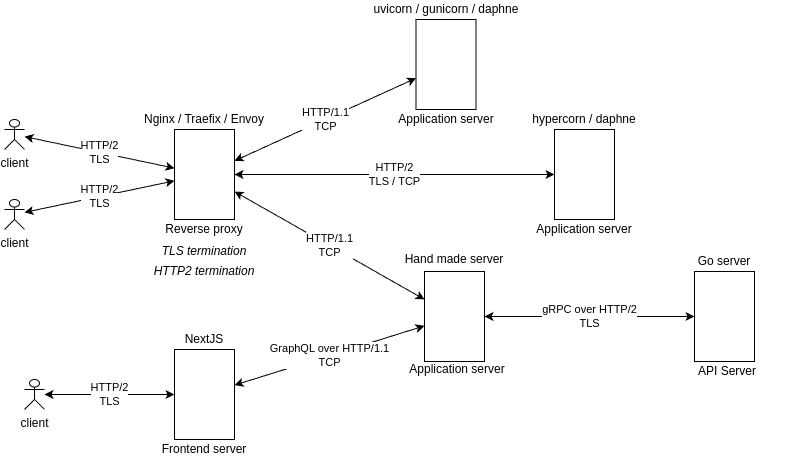

## Протокол Websocket

### Общая информация

WebSocket - это протокол связи, предоставляющий каналы полного дуплекса по единому TCP-соединению. [RFC 6455](https://datatracker.ietf.org/doc/html/rfc6455)

Он предназначен для использования в веб-приложениях для облегчения взаимодействия в реальном времени между клиентом и сервером. Вебсокеты позволяют открывать постоянные соединения между сервером и клиентом, что позволяет обоим сторонам отправлять данные в любое время

Клиент инициирует Websocket соединения в рамках общения по HTTP/1.1 протоколу:

```txt
GET /websocket HTTP/1.1
Host: my.server.com:9090
Upgrade: websocket
Connection: Upgrade
```

Преимущества использования WebSocket:
- Мгновенное взаимодействие: WebSocket идеально подходят для приложений, где требуется  взаимодействие в реальном времени, например, чаты, онлайн-игры, финансовые панели.
- Экономия ресурсов: После установления соединения WebSocket, обе стороны могут обмениваться данными  без повторных запросов HTTP, что экономит ресурсы и уменьшает задержки.
- Простота использования: Поддерживается большинством современных веб-браузеров и серверных технологий.

Недостатки и проблемы:
- Несовместимость с устаревшими системами: Некоторые старые системы и прокси-серверы могут не поддерживать WebSocket.
- Ограничения сети: Некоторые корпоративные сети и брандмауэры могут блокировать WebSocket соединения.

### Библиотека `websockets`

В стандартной библиотеке нет реализации протокола WebSocket

Для реализации серверов и клиентов нужно использовать стороннюю библиотеку `websockets`

Пример реализации Websocket сервера

In [18]:
# file: ws_server.py

import asyncio

import websockets

CONNECTIONS = set()


async def echo_handler(websocket: websockets.ServerConnection) -> None:
    print(f"новое подключение от {websocket.remote_address}")

    CONNECTIONS.add(websocket)

    async for client_message in websocket:
        # обрабатываем сообщение в соответствии с нашим протоколом
        client_message = client_message.upper()
        # отправляем ответ
        await websocket.send(client_message)

    print(f"клиент {websocket.remote_address} отключился")

    CONNECTIONS.remove(websocket)


async def broadcast_healthcheck():
    # раз в 1 секунду отпарвляет широковещательное сообщение клиентам
    while True:
        websockets.broadcast(CONNECTIONS, "как дела клиент?")
        await asyncio.sleep(1)


async def ws_server() -> None:
    server = await websockets.serve(echo_handler, "127.0.0.1", 9090)

    asyncio.create_task(broadcast_healthcheck())

    await server.serve_forever()

Пример реализации Websocket клиента

In [19]:
# file: ws_client.py

import asyncio

import websockets


async def make_request():
    uri = "ws://127.0.0.1:9090"

    async with websockets.connect(uri) as websocket:
        count = 1
        while True:
            message = f"hi server {count}!"

            await websocket.send(message)
            response = await websocket.recv()

            print(f"сообщение от сервера: {response}")

            await asyncio.sleep(1)

            count += 1

## Домашнее задание: HTTP сервер

Разработать сервер, частично реализующий протокол HTTP, в частности методы GET и HEAD, добиться того, что код проходит предоставленные функциональныe тесты

Архитектуру выбрать на свое усмотрение

Провести нагрузочное тестирование с помощью `ab` или `wrk`

## Итоги

1. Рассмотрели низкоуровневые механизмы клиент-серверного взаимодействия
2. Изучили модули стандартной библиотеки для создания клиент-серверных приложений 
3. Изучили основные виды архитектур веб серверов
4. Сравнили версии протокола HTTP и их применимость
5. Рассмотрели протокол Websocket и случаи его использования